In [279]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import sys
sys.path.append('./helpers')
import loadmat as lm
import glob
import helpers
import tensortools as tt

In [118]:
files = glob.glob('F:/NP_DATA/npF4*_gain*.mat')
files

['F:/NP_DATA\\npF4_1023_gaincontrast_1.mat',
 'F:/NP_DATA\\npF4_1025_gaincontrast_2.mat']

In [119]:
data = lm.loadmat(files[1])

# turn posx into a binned vector

In [120]:
pos_edges = np.arange(0,401,5)
posx = data['posx']
posx[posx>=400]=399.99
posx[posx<0]=0
location_vec=np.digitize(posx,pos_edges)-1

## extract good cells and label them from 0 to n

In [121]:
good_cells = data['sp']['cids'][data['sp']['cgs']==2]
validSpikes = np.in1d(data['sp']['clu'],good_cells)
spike_clu = data['sp']['clu'][validSpikes]
(bla,spike_idx) = np.unique(spike_clu,return_inverse=True)


In [122]:
spiketimes = np.digitize(data['sp']['st'][validSpikes],data['post'])
spikelocations = location_vec[spiketimes]
trial_idx = data['trial'][spiketimes]-1
n_trials = 30

In [126]:
def _fast_occ(occupancy,trials,bins):
    """ calculate occupancy for each position bin returns occupancy bins x trials"""
    
    for i,j in zip(trials,bins):
        if (j<0) or j>=occupancy.shape[0] or i>=occupancy.shape[1]:
            pass
        else:
            occupancy[j,i]+=1
            

In [127]:
occ2 = np.zeros((len(pos_edges)-1,n_trials),dtype = float)
_fast_occ(occ2,data['trial']-1,location_vec)

In [130]:
#@numba.jit(nopython=True)
def _fast_bin(counts, trials, bins, neurons):
    """
    Given coordinates of spikes, compile binned spike counts. Throw away
    spikes that are outside of tmin and tmax.
    Turns into a matrix neurons x bins x trials
    """
    for i, j, k in zip(trials, bins, neurons):
        if (j < 0) or (int(j) >= counts.shape[1]) or i>=counts.shape[2]:
            pass
        else:
            counts[k, int(j), i] += 1
            
    #return counts

In [131]:
n_cells = len(good_cells)
shape = (n_cells, len(pos_edges)-1, n_trials)
counts = np.zeros(shape, dtype=float)


In [132]:
_fast_bin(counts,trial_idx,spikelocations,spike_idx)

In [133]:
spMapN = np.zeros(counts.shape)
for iC in range(n_cells):
    spMapN[iC,:,:]=np.divide(counts[iC,:,:],occ2)

In [169]:
occ2.shape

(80, 30)

In [181]:
for iT in range(n_trials):
    tmp = occ2[:,iT]
    idx_v = np.flatnonzero(tmp)
    idx_n = np.flatnonzero(tmp==0)
    tmp[idx_n]=np.interp(idx_n,idx_v,tmp[idx_v])
    occ2[:,iT]=tmp

                           


In [184]:
counts.shape

(218, 80, 30)

In [185]:
import scipy.ndimage as spi
spF = spi.gaussian_filter(spMapN,(0,5,0))

In [305]:
n_cells = len(good_cells)
n_bins = len(pos_edges)-1
spFlat = np.zeros((n_cells,n_trials*n_bins))

for iC in range(n_cells):
    spFlat[iC,:]=spF[iC,:,:].ravel(order='F')
    

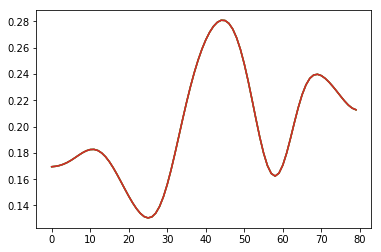

In [263]:
plt.plot(spF[2,:,1])
tmp = spF[2,:,:]
gg=tmp.ravel(order='F')
plt.plot(tmp[:,1])
plt.plot(gg[80:160])
plt.plot(spFlat[2,80:160])

In [306]:
from sklearn.preprocessing import normalize
tmp = spFlat.mean(axis=1).transpose();
spFlat = spFlat-tmp[:,np.newaxis]


spFlat = normalize(spFlat,axis=0,norm='l2')

In [265]:
gg=spFlat.mean(axis=0)
gg.shape
spFlat = spFlat-gg

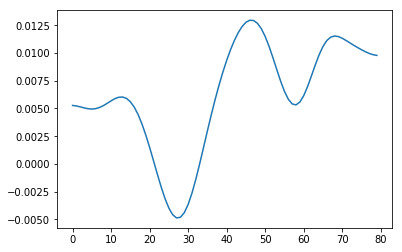

In [266]:
plt.plot(spFlat[2,80:160])

In [269]:
ff=np.cov(spFlat,rowvar=False)
ff.shape

(2400, 2400)

In [307]:
ff=np.matmul(np.transpose(spFlat),spFlat)

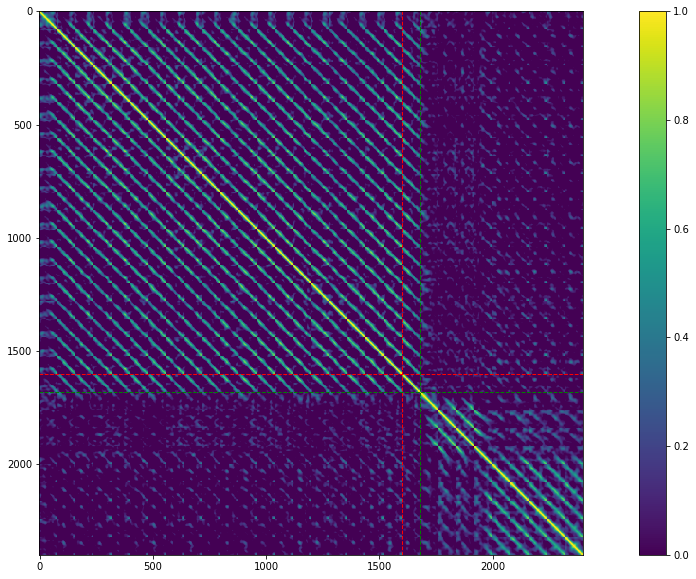

In [334]:
plt.figure(figsize=(20,10))
ax = plt.imshow(ff,origin='upper')
ax.set_clim([0, 1])

plt.colorbar()


plt.axvline(x=n_bins*20,color='red',ls='--',linewidth=1)
plt.axvline(x=n_bins*21,color='green',ls='--',linewidth=1)
plt.axhline(y=n_bins*20,color='red',ls='--',linewidth=1)
plt.axhline(y=n_bins*21,color='green',ls='--',linewidth=1)

#plt.xlim(-1.0,1.0)
#plt.ylim(-1.0,1.0)

In [322]:
ff.shape

(2400, 2400)

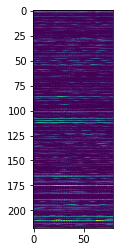

In [135]:
plt.imshow(spMap)

In [280]:
R=10
# Fit CP tensor decomposition (two times).
U = tt.ncp_bcd(spF, rank=R, verbose=True)
V = tt.ncp_bcd(spMapN, rank=R, verbose=True)



NCP_BCD: iteration 1, objective 0.4190998637703041, improvement inf.
NCP_BCD: iteration 2, objective 0.39765357569225795, improvement 0.02144628807804616.
NCP_BCD: iteration 3, objective 0.3903785590367942, improvement 0.007275016655463762.
NCP_BCD: iteration 4, objective 0.3862877851042936, improvement 0.004090773932500569.
NCP_BCD: iteration 5, objective 0.38304585160897003, improvement 0.00324193349532359.
NCP_BCD: iteration 6, objective 0.37999371842933033, improvement 0.0030521331796397044.
NCP_BCD: iteration 7, objective 0.37674965420262824, improvement 0.0032440642267020925.
NCP_BCD: iteration 8, objective 0.3729411661046508, improvement 0.0038084880979774582.
NCP_BCD: iteration 9, objective 0.36822702660329953, improvement 0.004714139501351244.
NCP_BCD: iteration 10, objective 0.3624412179978946, improvement 0.005785808605404952.
NCP_BCD: iteration 11, objective 0.355615438886322, improvement 0.006825779111572561.
NCP_BCD: iteration 12, objective 0.3480800716310159, improvement

NCP_BCD: iteration 94, objective 0.26880309385101736, improvement 2.997955198430491e-05.
NCP_BCD: iteration 95, objective 0.268773973756472, improvement 2.9120094545365127e-05.
NCP_BCD: iteration 96, objective 0.26874695268315085, improvement 2.7021073321142897e-05.
NCP_BCD: iteration 97, objective 0.2687218321631866, improvement 2.5120519964227928e-05.
NCP_BCD: iteration 98, objective 0.26869891917990485, improvement 2.291298328177538e-05.
NCP_BCD: iteration 99, objective 0.2686783732478812, improvement 2.0545932023663394e-05.
NCP_BCD: iteration 100, objective 0.26865962539396776, improvement 1.8747853913425594e-05.
NCP_BCD: iteration 101, objective 0.2686437017126325, improvement 1.5923681335239248e-05.
NCP_BCD: iteration 102, objective 0.2686300892420946, improvement 1.3612470537938126e-05.
NCP_BCD: iteration 103, objective 0.2686180450514254, improvement 1.204419066919149e-05.
NCP_BCD: iteration 104, objective 0.26860827241853985, improvement 9.772632885540755e-06.
Converged after 

NCP_BCD: iteration 82, objective 0.6638857652762548, improvement 1.7610856861471902e-05.
NCP_BCD: iteration 83, objective 0.6638693187768621, improvement 1.6446499392697156e-05.
NCP_BCD: iteration 84, objective 0.6638538338988887, improvement 1.5484877973315214e-05.
NCP_BCD: iteration 85, objective 0.6638393197549253, improvement 1.451414396347328e-05.
NCP_BCD: iteration 86, objective 0.6638258558307988, improvement 1.3463924126488891e-05.
NCP_BCD: iteration 87, objective 0.6638131250734788, improvement 1.273075732000084e-05.
NCP_BCD: iteration 88, objective 0.6638010037695009, improvement 1.2121303977874476e-05.
NCP_BCD: iteration 89, objective 0.6637894753996981, improvement 1.1528369802782379e-05.
NCP_BCD: iteration 90, objective 0.6637785588843458, improvement 1.0916515352343836e-05.
NCP_BCD: iteration 91, objective 0.6637682100452535, improvement 1.0348839092233497e-05.
NCP_BCD: iteration 92, objective 0.663758449660924, improvement 9.760384329537963e-06.
Converged after 92 iterat

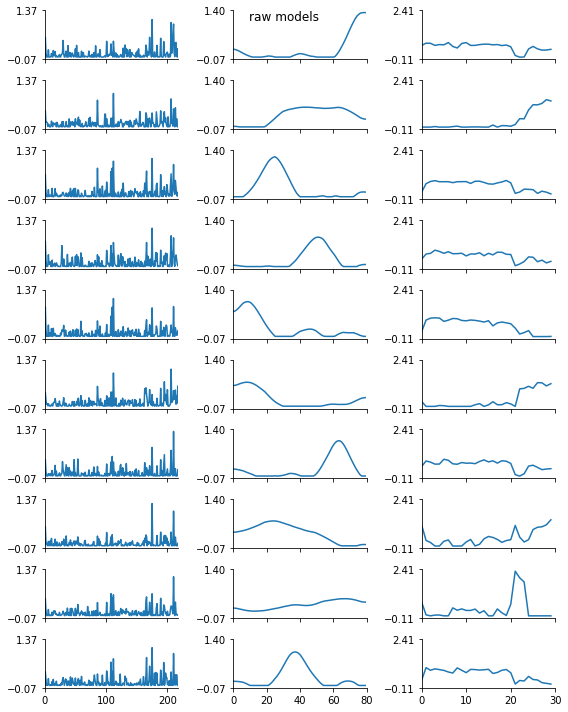

In [293]:
# Compare the low-dimensional factors from the two fits.
#f, (ax) = plt.subplots(10, 3)
fig, ax, po = tt.plot_factors(U.factors)
#tt.plot_factors(V.factors, fig=fig)
fig.suptitle("raw models")
fig.tight_layout()

In [289]:
ax.shape

(10, 3)

In [276]:

# Align the two fits and print a similarity score.
sim = tt.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True)
#print(sim)

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)
fig.suptitle("aligned models")
fig.tight_layout()

AttributeError: 'numpy.ndarray' object has no attribute 'kruskal_align'

Rank-5 models:  min obj, 0.69;  max obj, 0.69;  time to fit, 1.0s


Rank-6 models:  min obj, 0.69;  max obj, 0.69;  time to fit, 1.1s


Rank-7 models:  min obj, 0.68;  max obj, 0.68;  time to fit, 1.2s


Rank-8 models:  min obj, 0.67;  max obj, 0.68;  time to fit, 1.4s


Rank-9 models:  min obj, 0.67;  max obj, 0.67;  time to fit, 1.3s


Rank-10 models:  min obj, 0.66;  max obj, 0.67;  time to fit, 1.6s


Rank-11 models:  min obj, 0.66;  max obj, 0.66;  time to fit, 1.5s


Rank-12 models:  min obj, 0.66;  max obj, 0.66;  time to fit, 1.6s


Rank-13 models:  min obj, 0.65;  max obj, 0.65;  time to fit, 2.1s


Rank-14 models:  min obj, 0.65;  max obj, 0.65;  time to fit, 2.2s


Rank-5 models:  min obj, 0.69;  max obj, 0.69;  time to fit, 0.2s


Rank-6 models:  min obj, 0.69;  max obj, 0.69;  time to fit, 0.2s


Rank-7 models:  min obj, 0.68;  max obj, 0.68;  time to fit, 0.3s


Rank-8 models:  min obj, 0.67;  max obj, 0.68;  time to fit, 0.2s


Rank-9 models:  min obj, 0.67;  max obj, 0.67;  time to fit, 0.3s


Rank-10 models:  min obj, 0.66;  max obj, 0.66;  time to fit, 0.3s


Rank-11 models:  min obj, 0.66;  max obj, 0.66;  time to fit, 0.4s


Rank-12 models:  min obj, 0.66;  max obj, 0.66;  time to fit, 0.3s


Rank-13 models:  min obj, 0.65;  max obj, 0.65;  time to fit, 0.3s


Rank-14 models:  min obj, 0.65;  max obj, 0.65;  time to fit, 0.5s


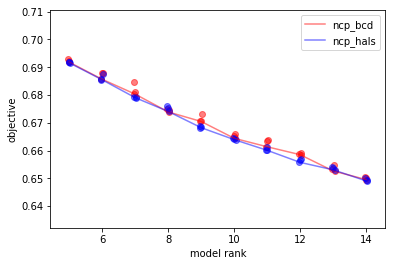

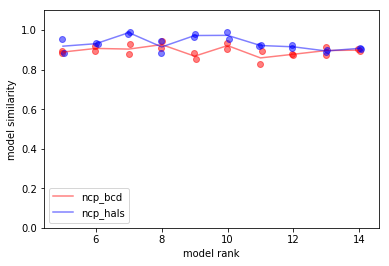

In [143]:
# Fit ensembles of tensor decompositions.
methods = (
    'ncp_bcd',   # fits nonnegative tensor decomposition.
  'ncp_hals',  # fits nonnegative tensor decomposition.
)


ensembles = {}
for m in methods:
    ensembles[m] = tt.Ensemble(fit_method=m, fit_options=dict(tol=1e-4))
    ensembles[m].fit(spMapN, ranks=range(5, 15), replicates=3)

# Plotting options for the unconstrained and nonnegative models.
plot_options = {
  'cp_als': {
    'line_kw': {
      'color': 'black',
      'label': 'cp_als',
    },
    'scatter_kw': {
      'color': 'black',
    },
  },
  'ncp_hals': {
    'line_kw': {
      'color': 'blue',
      'alpha': 0.5,
      'label': 'ncp_hals',
    },
    'scatter_kw': {
      'color': 'blue',
      'alpha': 0.5,
    },
  },
  'ncp_bcd': {
    'line_kw': {
      'color': 'red',
      'alpha': 0.5,
      'label': 'ncp_bcd',
    },
    'scatter_kw': {
      'color': 'red',
      'alpha': 0.5,
    },
  },
}

# Plot similarity and error plots.
plt.figure()
for m in methods:
    tt.plot_objective(ensembles[m], **plot_options[m])
plt.legend()

plt.figure()
for m in methods:
    tt.plot_similarity(ensembles[m], **plot_options[m])
plt.legend()

plt.show()
